<a href="https://colab.research.google.com/github/russelljjarvis/netpyneunit/blob/main/docs/PDCM_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/lakesare/netpyneunit/blob/main/docs/PDCM_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



---



# Description

This example recreates the [PDCM paper](https://direct.mit.edu/neco/article-pdf/33/7/1993/1925382/neco_a_01400.pdf) (Romaro & Salvador Dura-Bernal, et al., 2021) in **SciUnit**.  

The **PDCM** (**Potjans-Diesmann Cortical Microcircuit**) paper describes the process of converting the model of the 1mm2 sensory cortical network from **NEST** to **NetPyNE**, and of rescaling the resulting **NetPyNE** network while preserving the first- and second-order statistics.  
See [Github](https://github.com/ceciliaromaro/PDCM_NetPyNE) for the **NetPyNE** code.

Our colab doesn't recreate the entire paper: the **run.py** file recreates **Table A1** and **Table A2**, and each of these will take hours to run on a single core.  
In this colab, we will show the **first 2 rows** of the **Table A1**: the **1%** and the **2%** **NetPyNE** model, tested for the population mean firing rate against the **100%**-sized network.  
The only difference between the code used in the original paper, and the code we use in this colab is that they run the simulation for 60 seconds, and we run it for 1 second - again, to shorten the waiting time. This does not affect the results significantly.

# Install the packages

In [1]:
%%capture
!pip install https://github.com/lakesare/netpyneunit/archive/refs/heads/main.zip
!pip install neuron
!git clone https://github.com/lakesare/netpyneunit.git

# Run the example

Enter the **PDCM example** directory: 

In [2]:
%cd netpyneunit/examples/pdcm

/content/netpyneunit/examples/pdcm


Compile our **examples/pdcm/*.mod** files:

In [3]:
!nrnivmodl

/content/netpyneunit/examples/pdcm
Mod files: "./intFire_PD.mod"

Creating x86_64 directory for .o files.

COBJS=''
 -> Compiling mod_func.c
x86_64-linux-gnu-gcc -O2   -I.   -I/usr/local/lib/python3.7/dist-packages/neuron/.data/include  -I/nrnwheel/openmpi/include -fPIC -c mod_func.c -o mod_func.o
 -> NMODL ../intFire_PD.mod
(cd ".."; MODLUNIT=/usr/local/lib/python3.7/dist-packages/neuron/.data/share/nrn/lib/nrnunits.lib /usr/local/lib/python3.7/dist-packages/neuron/.data/bin/nocmodl intFire_PD.mod -o "/content/netpyneunit/examples/pdcm/x86_64")
Translating intFire_PD.mod into /content/netpyneunit/examples/pdcm/x86_64/intFire_PD.c
Thread Safe
 -> Compiling intFire_PD.c
x86_64-linux-gnu-gcc -O2   -I".." -I.   -I/usr/local/lib/python3.7/dist-packages/neuron/.data/include  -I/nrnwheel/openmpi/include -fPIC -c intFire_PD.c -o intFire_PD.o
 => LINKING shared library ./libnrnmech.so
x86_64-linux-gnu-g++ -O2 -DVERSION_INFO='8.0.0' -std=c++11 -shared -fPIC  -I /usr/local/lib/python3.7/dist-pac

Import the **examples/pdcm/*** classes.  

In [4]:
import sciunit
from PdcmModel import PdcmModel
from tests import PopulationMeanFiringRateTest

Config file not found at '/root/.sciunit/config.json'; creating new one


### Surveying Table A1

Let's take a look at **Table A1** of the [PDCM paper](https://direct.mit.edu/neco/article-pdf/33/7/1993/1925382/neco_a_01400.pdf).  
The **NEST trial** row shows the stats of the **NEST** model (Gewaltig
& Diesmann, 2007) the paper tried to recreate.  
The **100%** row shows the stats of the full-scale **NetPyNE** model.  
The **80%**, **...**, **1%** rows show the stats of various scalings of the **NetPyNE** model.

___ 

A brief note on what it means to *rescale* the model of a neural network.  
The **100% NetPyNE** network contains exactly **77169** neurons.  
We cannot simply cut the number of neurons down to **7717**, and expect our network to be comparable to the full-sized network - we need to additionally adapt the number of connections, external inputs and synaptic weights.

To quote the PDCM paper, we need to:
1. Multiply number of cells in each population by k.
2. Multiply number of connections per population by k^2.
3. Multiply synaptic weights by 1/√k .
4. Calculate lost input for each cell and provide compensatory DC input
current.

in order to preserve first- and second-order statistics of our model. 

This is done in the `Reescale` method in our `PdcmModel` (see [line 108](https://github.com/lakesare/netpyneunit/blob/432533cf70f4225b056ec0832340358b2f4d6a97/examples/pdcm/PdcmModel.py#L108)).  
Every time we write `PdcmModel(name="2%", scale=0.02, ...)` - this method helps us determine **NetPyNE** parameters that would, hopefully, result in preserving the results of the model with `scale=1`.

___

We take the stats of the **100% NetPyNE** model as our ideal result (or observation in the parlance of **SciUnit**), and try to determine how closely **1%** and **2%-scaled NetPyNE** models can match it.

<img width=800 src="https://drive.google.com/uc?id=1l2nFa4iz4Vb4wDkynHIiHcyqrpDA-paf"/>

### Defining our models

**PdcmModel** injects the global `sim` object with the data suitable for the current model.  
Once a particular model (e.g. `model_1`) runs, the results will be cached.  
For example, if we didn't have cache enabled, each test would rerun the model. Currently, only the first test will execute `sim.runSim()`.

Just like in the **Table A1**, the external input for our sims is **Balanced Poisson**.  
The **duration**, however, is set to **1 second**. Feel free to change it to **60 seconds** if you're willing to sacrifice some time to hit closer to the results in the paper!


In [5]:
model_2 = PdcmModel(name="2%", scale=0.02, ext_input="balanced_poisson", duration=1*1e3)
model_1 = PdcmModel(name="1%", scale=0.01, ext_input="balanced_poisson", duration=1*1e3)

### Setting up our tests  

Each `'value'` represents the perfect value our resized models should strive to achieve.  
For example, the **100% NetPyNE** model has the **population mean firing rate** of **0.90** in the layer **L2e/L3e**.  
We hope our **model_1** and **model_2** have similar stats in this layer.  

Just like in the paper, we want to see the "**relative deviation**" between the perfect value and the model result. Our `PopulationMeanFiringRateTest` calculates this value using the `sciunit.scores.RelativeDifferenceScore` class native to **SciUnit**.


In [6]:
%%capture
test_L2e = PopulationMeanFiringRateTest({ 'value': 0.90, 'layer': 'L2e' }, name='L2e')
test_L2i = PopulationMeanFiringRateTest({ 'value': 2.80, 'layer': 'L2i' }, name='L2i')
test_L4e = PopulationMeanFiringRateTest({ 'value': 4.39, 'layer': 'L4e' }, name='L4e')
test_L4i = PopulationMeanFiringRateTest({ 'value': 5.70, 'layer': 'L4i' }, name='L4i')
test_L5e = PopulationMeanFiringRateTest({ 'value': 6.80, 'layer': 'L5e' }, name='L5e')
test_L5i = PopulationMeanFiringRateTest({ 'value': 8.22, 'layer': 'L5i' }, name='L5i')
test_L6e = PopulationMeanFiringRateTest({ 'value': 1.14, 'layer': 'L6e' }, name='L6e')
test_L6i = PopulationMeanFiringRateTest({ 'value': 7.60, 'layer': 'L6i' }, name='L6i')

suite = sciunit.TestSuite(
  [test_L2e, test_L2i, test_L4e, test_L4i, test_L5e, test_L5i, test_L6e, test_L6i],
  name="Population Mean Firing Rate: Balanced Poisson"
)
score_matrix = suite.judge(
  [model_2, model_1]
)

Score: 0.69 (23.06%) for 2% on L2e
Score: 3.84 (37.32%) for 2% on L2i
Score: 4.30 (2.12%) for 2% on L4e
Score: 5.95 (4.46%) for 2% on L4i
Score: 7.25 (6.58%) for 2% on L5e
Score: 8.62 (4.85%) for 2% on L5i
Score: 0.98 (14.42%) for 2% on L6e
Score: 7.98 (5.04%) for 2% on L6i
Score: 0.75 (16.40%) for 1% on L2e
Score: 4.21 (50.25%) for 1% on L2i
Score: 3.92 (10.65%) for 1% on L4e
Score: 5.46 (4.16%) for 1% on L4i
Score: 8.62 (26.84%) for 1% on L5e
Score: 8.90 (8.27%) for 1% on L5i
Score: 0.99 (13.51%) for 1% on L6e
Score: 7.66 (0.73%) for 1% on L6i


### Finally, the results

Take a look at the **NetpyneUnit** table below, and compare it to the **Table A1** from the paper.

`___Table A1, 2% model, L2e:` **0.69 (23%)**  
`Our results, 2% model, L2e:` **0.69 (23.06%)**  

`___Table A1, 1% model, L2e:` **0.71 (21%)**   
`Our results, 1% model, L2e:` **0.75 (16.40%)**  

`___Table A1, 2% model, L2i:` **3.8 (36%)**  
`Our results, 2% model, L2e:` **3.84 (37.32%)**  

🍀 **Our results match the results in the paper** 🍀  
(It's also expected that our results won't match completely.
The initial values for the membrane potential of each neuron in our **NetPyNE** model are randomized; the **Balanced Poisson** external input additionally introduces other sources of randomness.
And again - we run our simulation for 1 second, they run it for 60 seconds)


In [16]:
score_matrix = pd.DataFrame(score_matrix)
score_matrix.T

,2%,1%
L2e,0.69 (23.06%),0.75 (16.40%)
L2i,3.84 (37.32%),4.21 (50.25%)
L4e,4.30 (2.12%),3.92 (10.65%)
L4i,5.95 (4.46%),5.46 (4.16%)
L5e,7.25 (6.58%),8.62 (26.84%)
L5i,8.62 (4.85%),8.90 (8.27%)
L6e,0.98 (14.42%),0.99 (13.51%)
L6i,7.98 (5.04%),7.66 (0.73%)


# Bonus content: a graph

Automating your test suite enables you to draw a graph illustrating your results on every test suite run virtually for free.  

Let's draw a graph that will show us which cortical layers are subjected to the higher error rate.  

Looking at the graph, we see that for the **2%** and **1%**-scale models, **L2e** and **L2i**-layer **mean population firing rates** were most unlike those in the **100%**-scale model (using the "relative deviation" measure).  
The PDCM paper took notice of this too: "*The populations with the largest relative deviations were L2/3e and L2/3i, but even these generally exhibited maximum relative deviations under 30% (scaling)*".

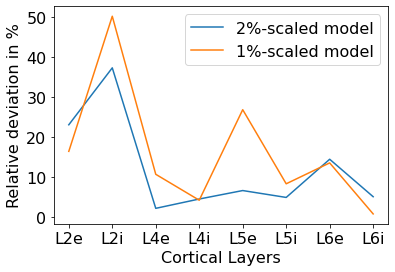

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

layers = ['L2e', 'L2i', 'L4e', 'L4i', 'L5e', 'L5i', 'L6e', 'L6i']
plt.plot(layers, score_matrix.scores.to_numpy()[0] * 100, label="2%-scaled model")
plt.plot(layers, score_matrix.scores.to_numpy()[1] * 100, label="1%-scaled model")
plt.xlabel("Cortical Layers")
plt.ylabel("Relative deviation in %")
plt.legend()
plt.show()